# **Quora Question Pairs**

**Problem Statement**

* Identify which questions asked on Quora are duplicates of questions that have already been asked.
* This could be useful to instantly provide answers to questions that have already been answered.
* We are tasked with predicting whether a pair of questions are duplicates or not.

In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

# Exploratory Data Analysis

In [0]:
df = pd.read_csv("/content/drive/My Drive/AI projects/Quora/train.csv")

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df.shape

(404290, 6)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

* id: Looks like a simple rowID
* qid{1, 2}: The unique ID of each question in the pair
* question{1, 2}: The actual textual contents of the questions.
* is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

**Distribution of data points among output classes**
- Number of duplicate(smilar) and non-duplicate(non similar) questions

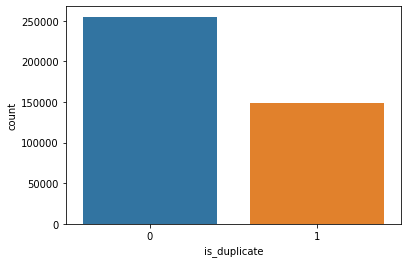

In [0]:
sns.countplot(df["is_duplicate"])
plt.show()

In [0]:
df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [0]:
print("Similar Question pairs: {} % ".format(round(df['is_duplicate'].mean()*100, 2)))
print("Different Question pairs: {} % ".format(100 - round(df['is_duplicate'].mean()*100, 2)))

Similar Question pairs: 36.92 % 
Different Question pairs: 63.08 % 


In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
repeated_qs = np.sum(qids.value_counts() > 1)
print("Total no. unique questions: ", unique_qs)
print("Toatal no. of repeated questios: ", repeated_qs)

Total no. unique questions:  537933
Toatal no. of repeated questios:  111780


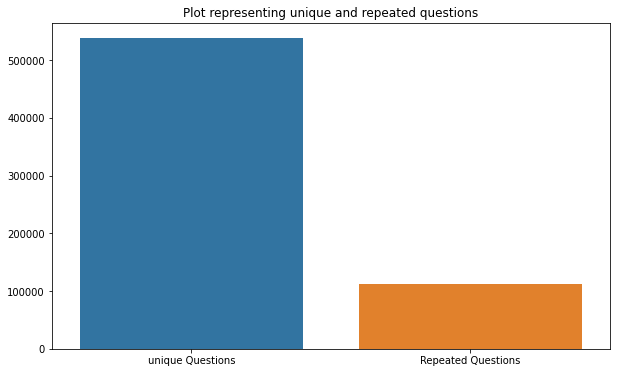

In [0]:
x = ["unique Questions", "Repeated Questions"]
y = [unique_qs, repeated_qs]

plt.figure(figsize = (10, 6))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x, y)
plt.show()

In [0]:
df.duplicated().any()

False

**Number of occurrences of each question**

Maximum no. of times a single question is repeated: 157


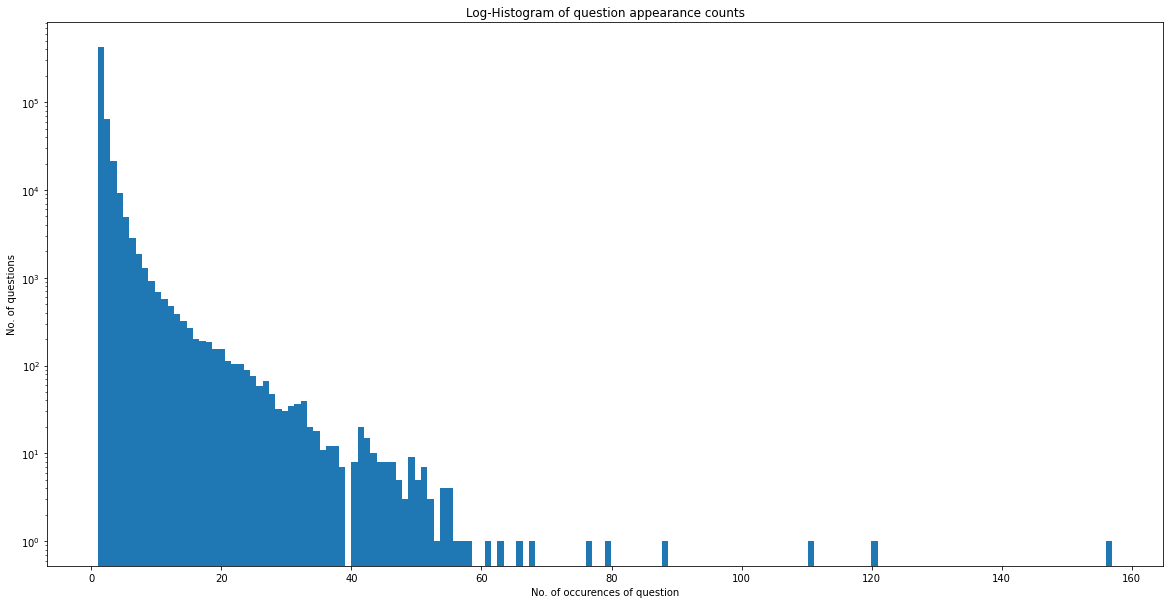

In [0]:
plt.figure(figsize = (20, 10))
plt.hist(qids.value_counts(), bins= 160)
plt.yscale('log', nonposy= 'clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('No. of occurences of question')
plt.ylabel('No. of questions')

print("Maximum no. of times a single question is repeated:", max(qids.value_counts()))

In [0]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [0]:
df = df.fillna('')
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

# Feature Extraction

Construct a few features like:

* **freq_qid1** = Frequency of qid1's
* **freq_qid2** = Frequency of qid2's
* **q1len** = Length of q1
* **q2len** = Length of q2
* **q1_n_words** = Number of words in Question 1
* **q2_n_words** = Number of words in Question 2
* **word_Common** = (Number of common unique words in Question 1 and Question 2)
* **word_Total** =(Total num of words in Question 1 + Total num of words in Question 2)
* **word_share** = (word_common)/(word_Total)
* **freq_q1+freq_q2** = sum total of frequency of qid1 and qid2
* **freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2

In [0]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_common_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * len(w1 & w2)

df['word_Common'] = df.apply(normalized_common_words, axis= 1)

def normalized_total_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * (len(w1) + len(w2))

df['word_Total'] = df.apply(normalized_total_words, axis= 1)

def normalized_shared_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * len(w1 & w2) / (len(w1) + len(w2))

df['word_share'] = df.apply(normalized_shared_words, axis= 1)

df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = df['freq_qid1'] - df['freq_qid2']

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


## Analysis of some of the extracted features



In [0]:
print("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


**Feature: word_share**

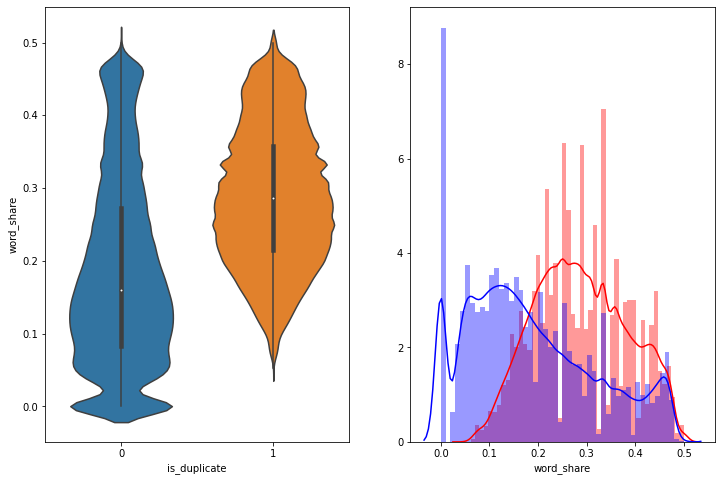

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

* The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
* The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

**Feature: word_Common**

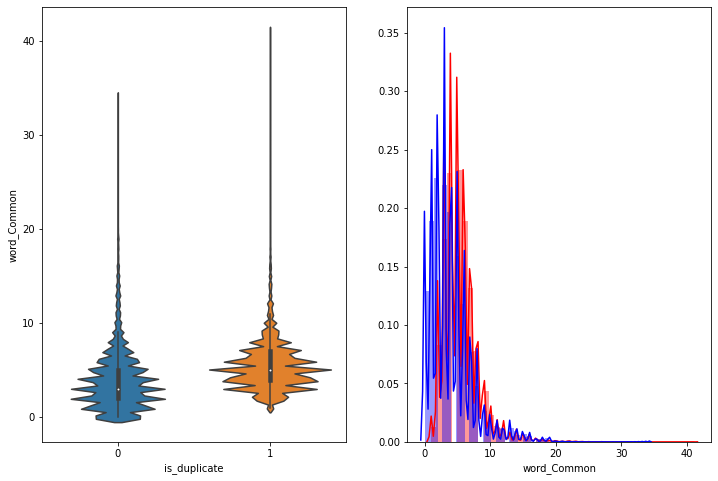

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions of the word_Common feature in similar and non-similar questions are highly overlapping

#  Preprocessing of Text

**Preprocessing**:
* Removing html tags
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

Function to Compute and get the features : With 2 parameters of Question 1 and Question 2


In [0]:
def preprocess(x):
  x = str(x).lower()
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                          .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                          .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                          .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                          .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                          .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                          .replace("€", " euro ").replace("'ll", " will")
  x = re.sub(r"([0-9]+)000000", r"\1m", x)
  x = re.sub(r"([0-9]+)000", r"\1k", x)

  porter = PorterStemmer()
  pattern = re.compile('\W')

  if type(x) == type(''):
    x = re.sub(pattern, ' ', x)

  if type(x) == type(''):
    x = porter.stem(x)
    ex = BeautifulSoup(x)
    x = ex.get_text()

  return x 

# Advanced Feature Extraction (NLP and Fuzzy Features)


Definition:

* **Token**: You get a token by splitting sentence a space
* **Stop_Word** : stop words as per NLTK.
Word : A token that is not a stop_word
Features:

* **cwc_min** : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

* **cwc_max** : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

* **csc_min** : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

* **csc_max** : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

* **ctc_min** : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

* **ctc_max** : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))

* **last_word_eq** : Check if First word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

* **first_word_eq** : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0])

* **abs_len_diff** : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

* **mean_len** : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2



* **fuzz_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

* **fuzz_partial_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

* **token_sort_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

* **token_set_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

* **longest_substr_ratio** : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [0]:
def get_token_features(q1, q2):
  token_features = [0.0] * 10

  # Converting the sentence into token
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
    return token_features

  # Get the non_stopwords in questions
  q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

  # Get the stopwords in questions
  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

  # Get the common non-stopwords from question pair
  common_word_count = len(q1_words.intersection(q2_words))

  # Get the common stopwords from question pair
  common_stop_count = len(q1_stops.intersection(q2_stops))

  # Get the common token from question pair
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
  token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

 # Last word of both question is same or not
  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

  # First word of both question is same or not
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])
  
  token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
  
  #Average Token Length of both Questions
  token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
  return token_features

In [0]:
# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
  strs = list(distance.lcsubstrings(a, b))
  if len(strs) == 0:
      return 0
  else:
      return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
  # preprocessing each question
  df["question1"] = df["question1"].fillna("").apply(preprocess)
  df["question2"] = df["question2"].fillna("").apply(preprocess)

  print("token features...")
  
  # Merging Features with dataset
  
  token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
  
  df["cwc_min"]       = list(map(lambda x: x[0], token_features))
  df["cwc_max"]       = list(map(lambda x: x[1], token_features))
  df["csc_min"]       = list(map(lambda x: x[2], token_features))
  df["csc_max"]       = list(map(lambda x: x[3], token_features))
  df["ctc_min"]       = list(map(lambda x: x[4], token_features))
  df["ctc_max"]       = list(map(lambda x: x[5], token_features))
  df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
  df["first_word_eq"] = list(map(lambda x: x[7], token_features))
  df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
  df["mean_len"]      = list(map(lambda x: x[9], token_features))
  
  #Computing Fuzzy Features and Merging with Dataset
  
  # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
  # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
  # https://github.com/seatgeek/fuzzywuzzy
  print("fuzzy features..")

  df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
  # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
  # then joining them back into a string We then compare the transformed strings with a simple ratio().
  df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
  df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
  df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
  df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
  return df

In [0]:
df = extract_features(df)
df.head()

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [0]:
df.to_csv("/content/drive/My Drive/AI projects/features_train.csv", index= False)

# Analysis of extracted features


### Plotting Word clouds

* Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
* We can observe the most frequent occuring words

In [0]:
df = pd.read_csv("/content/drive/My Drive/AI projects/features_train.csv")

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

# converting 2d array of q1 and q2 into 1d
textp = np.dstack((df_duplicate['question1'], df_duplicate['question2'])).flatten()
textn = np.dstack((df_nonduplicate['question1'], df_nonduplicate['question2'])).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(textp))
print ("Number of data points in class 0 (non duplicate pairs) :",len(textn))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [0]:
textp_w = " ".join(str(words) for words in textp)
textn_w = " ".join(str(words) for words in textn)

In [0]:
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109885
Total number of words in non duplicate pair questions : 33193129


In [0]:
# remove stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

Word Cloud for Duplicate Question pairs


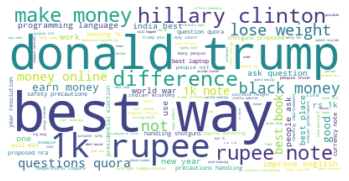

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords= stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


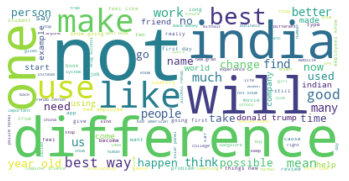

In [0]:
wc = WordCloud(background_color= "white", max_words= len(textn_w), stopwords= stopwords)
wc.generate(textn_w)
print("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation= 'bilinear')
plt.axis("off")
plt.show()

Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

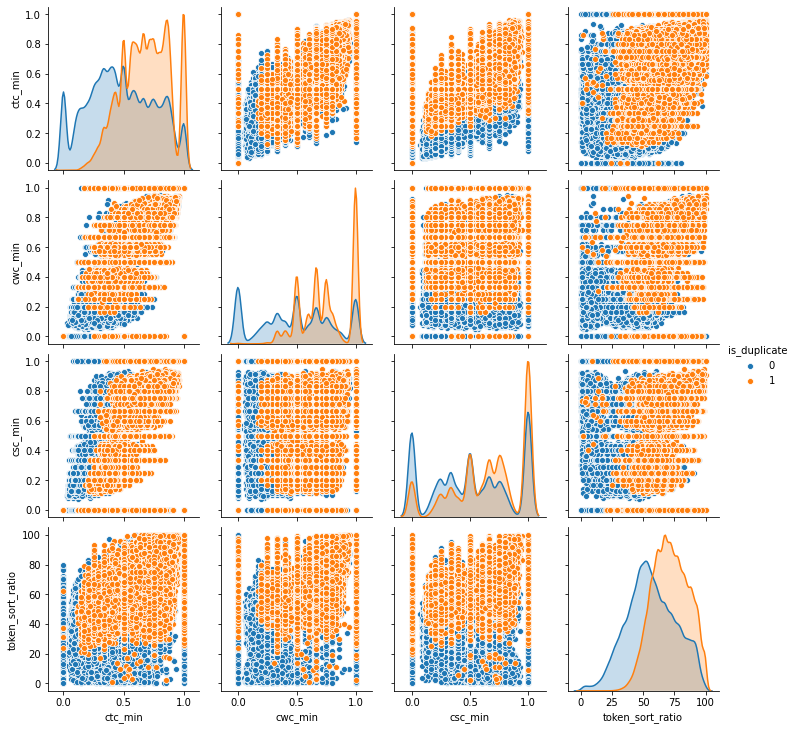

In [0]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

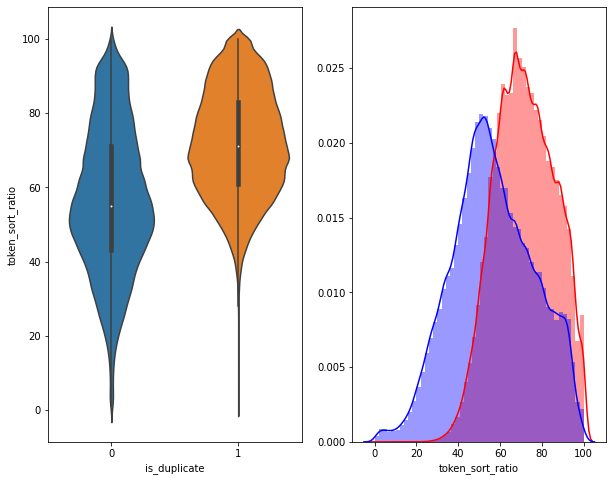

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

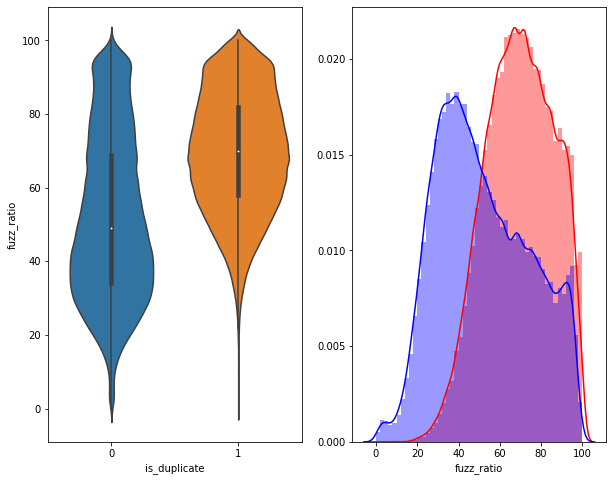

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## Visualization

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.399s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.311s
[t-SNE] Iteration 50: error = 81.3346405, gradient norm = 0.0466835 (50 iterations in 2.441s)
[t-SNE] Iteration 100: error = 70.6411362, gradient norm = 0.0087385 (50 iterations in 1.685s)
[t-SNE] Iteration 150: error = 68.9421158, gradient norm = 0.0055224 (50 iterations in 1.606s)
[t-SNE] Iteration 200: error = 68.1217880, gradient norm = 0.0044136 (50 iterations in 1.668s)
[t-SNE] Iteration 250: error = 67.6154175, gradient norm = 0.0040027

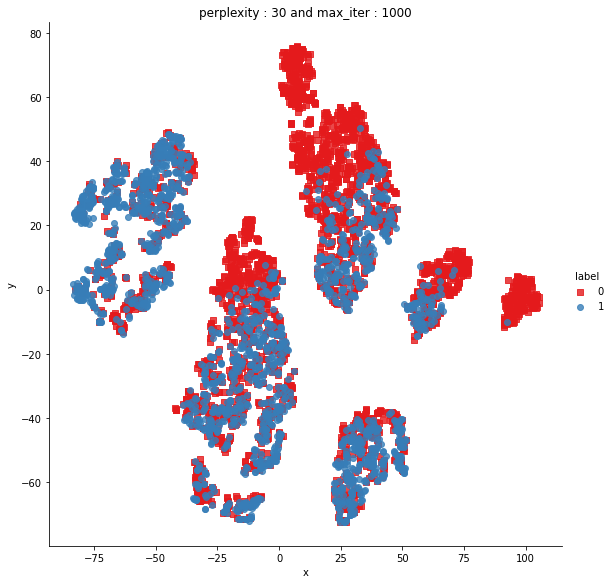

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 0.400s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.308s
[t-SNE] Iteration 50: error = 80.5661621, gradient norm = 0.0296227 (50 iterations in 10.079s)
[t-SNE] Iteration 100: error = 69.4089432, gradient norm = 0.0033432 (50 iterations in 4.707s)
[t-SNE] Iteration 150: error = 67.9962845, gradient norm = 0.0018752 (50 iterations in 4.352s)
[t-SNE] Iteration 200: error = 67.4377289, gradient norm = 0.0011330 (50 iterations in 4.338s)
[t-SNE] Iteration 250: error = 67.1244202, gradient norm = 0.000859

In [0]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
#py.iplot(fig, filename='3DBubble')
py.plot(fig, filename='3DBubble')

'3DBubble.html'

# Featurizing text data with tfidf weighted word-vectors

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [0]:
df = pd.read_csv("/content/drive/My Drive/AI projects/Quora/train.csv")

In [0]:
# encode questions to unicode
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase= False)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

* After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
* here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
* It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 =[]
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar

for qu1 in tqdm(list(df['question1'])):
  doc1 = nlp(qu1)
  #384 is the number of dimensions of vectors
  mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)]) 
  for word1 in doc1:
    #word2vec
    vec1 = word1.vector
    #fetch df score
    try:
      idf = word2tfidf[str(word1)]
    except:
      idf = 0
    
    # compute final vec
    mean_vec1 += vec1 * idf
  mean_vec1 = mean_vec1.mean(axis= 0)
  vecs1.append(mean_vec1)

df['q1_feats_m'] = list(vecs1)
 

100%|██████████| 404290/404290 [1:00:56<00:00, 110.58it/s]


In [0]:
df2 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2_q1 = pd.DataFrame(df2.q1_feats_m.values.tolist(), index= df2.index)
df2_q1.to_csv("/content/drive/My Drive/AI projects/q1_features_train.csv", index= False)

In [0]:
nlp = spacy.load('en_core_web_sm')

vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [58:20<00:00, 115.48it/s]


In [0]:
df2 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2_q2 = pd.DataFrame(df2.q2_feats_m.values.tolist(), index= df2.index)
df2_q2.to_csv("/content/drive/My Drive/AI projects/q2_features_train.csv", index= False)

In [0]:
df = pd.read_csv("/content/drive/My Drive/AI projects/Quora/train.csv")

In [0]:
df_q1 = pd.read_csv("/content/drive/My Drive/AI projects/q1_features_train.csv")

In [0]:
df_q2 = pd.read_csv("/content/drive/My Drive/AI projects/q2_features_train.csv")

In [0]:
df3 = pd.read_csv("/content/drive/My Drive/AI projects/features_train.csv")

In [0]:
df1 = df.drop(['qid1','qid2','question1','question2'],axis=1)
df3 = df3.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [0]:
df3.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [0]:
df_q1.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,-6.616976,-94.064813,-31.617267,-29.205890,-39.608413,30.163852,67.357976,56.346944,7.606743,20.720049,-56.899175,-41.419606,30.634747,-20.667785,93.049776,-108.506989,134.494691,-69.708587,57.891030,-94.501012,-34.043306,-88.044590,197.875458,-56.918224,-33.153865,...,114.638685,50.816876,-57.381595,106.554903,98.567380,-67.311119,88.728154,48.158799,-12.962363,-108.238607,77.740890,-76.930486,-55.488544,55.403322,-134.602412,15.887729,-14.812700,-43.172916,-71.213891,66.473449,138.864320,-134.555638,11.072384,11.770594,23.349589,-83.244351,-55.722126,-21.893210,8.263763,-14.915859,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,1,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,-103.803116,-78.503396,11.997354,73.522302,-3.368269,-61.134586,1.137853,-47.250332,-14.747230,-111.214488,-92.936345,-86.908993,26.479862,-125.349442,53.630314,-118.244944,-19.311728,4.184269,37.147654,-32.207492,54.693156,-146.564649,190.351235,-50.185377,-102.660014,...,69.116646,123.042798,2.978409,-52.171842,-77.587376,-43.825259,-2.570918,25.001977,74.528037,55.402768,53.763126,-27.621300,-62.024373,67.296625,-127.672300,5.919581,51.888908,5.646263,-52.011487,-22.036677,150.269148,-19.587007,-46.445237,-12.489538,104.020920,-83.863392,-11.340908,26.339330,16.131961,137.782501,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,2,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,49.411453,4.386397,-23.508985,3.867846,-19.287308,-52.332033,59.900114,102.718565,-6.070379,-47.957186,-51.316635,26.235306,-71.297170,-82.694041,61.166595,-59.661620,85.192997,95.725261,-9.786940,-44.572019,-26.737537,-8.913334,67.037574,-85.818559,-137.332815,...,126.969506,32.991508,11.751381,32.921630,127.876085,-117.452091,-53.697893,116.449840,-7.114503,-28.417017,22.236688,-95.365500,-13.684289,67.952175,-19.670386,0.049363,63.119457,21.524016,-36.342319,7.531785,101.659882,-90.213289,-11.944407,-20.185547,16.732628,9.608647,-77.976104,77.923826,59.257286,-78.643996,-66.835015,87.592131,4.032431,56.851709,-43.625410,-57.580963,-50.425829,78.591986,105.714348,-33.304161
3,3,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,61.735411,147.720951,-76.666564,-61.303286,-63.827246,8.319557,-32.426865,-6.724337,-28.032162,-32.440859,25.425998,125.724761,5.593011,-111.110888,-10.119862,-23.430039,-38.038687,-19.025249,38.910990,-52.249356,-13.859811,-56.759533,19.452093,-96.299227,-86.240144,...,99.160310,22.281756,-18.003228,20.443845,17.556030,-152.605936,-27.253293,2.113273,9.557493,-13.790257,-97.305417,11.291192,71.311880,20.816198,-23.316110,-17.823973,48.085230,30.902770,-5.960159,-99.039773,125.188415,-17.051089,-43.028228,79.045821,37.998520,-86.332762,-23.401571,55.163438,-13.930802,-25.005486,28.362956,41.981221,-11.204984,16.833434,-36.372471,8.927573,-64.553194,95.054238,-34.157566,70.821932
4,4,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,62.088563,51.716923,-82.084056,-35.192773,-53.508376,-53.804667,124.787429,5.007129,-58.838039,-17.581073,-89.628781,21.836286,7.694493,-164.066897,159.268660,-92.885525,63.914158,82.922555,54.042456,-58.458466,-18.022328,-90.972944,67

In [0]:
df_q1 = df_q1.drop("Unnamed: 0", axis= 1)

In [0]:
df_q2.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0,-14.616981,59.755488,-53.263745,19.514497,113.916473,101.657056,8.561499,66.232769,32.888127,210.812733,-14.521656,5.732026,40.648458,-95.787979,-1.157125,-66.563451,-31.051373,-17.968147,-30.063745,32.889709,65.430540,54.742656,1.756501,27.786168,-46.373962,-25.822312,51.231668,-20.655695,98.152685,-96.048390,126.935466,-28.066691,82.523253,-91.751655,-24.696691,-67.690101,171.840663,-62.797236,-22.777055,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,1,-3.565742,-16.844571,-130.911785,0.320254,79.350278,23.562028,79.124551,84.119839,128.684135,279.539877,51.329233,-47.977027,124.322700,-106.766716,-35.756386,-119.277429,21.692362,79.320570,-30.874480,-86.451965,-75.311001,-10.504030,-54.459205,-82.283126,-122.537507,-23.897150,38.062149,-120.668866,96.555255,-172.800629,71.174992,52.399280,-3.790546,-88.446559,-1.359644,-169.229485,242.162139,-106.348765,-118.454241,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,2,156.833630,59.991896,-8.414311,29.251426,133.680218,112.457566,89.849781,21.613022,24.331766,171.114490,-104.683288,-27.202060,-45.827002,-96.844532,-12.986917,43.818585,20.793440,15.393396,0.015373,-28.024086,-12.633978,11.869804,-52.478160,-3.826736,8.331102,21.353006,-36.579113,-14.109747,43.868416,-107.133660,125.654210,-0.800086,39.060021,-50.904144,37.683092,-78.781466,122.383833,-67.524980,-107.706957,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,3,41.472439,56.717317,31.530616,-5.520164,33.454800,79.596179,15.508996,40.042066,21.094017,101.998116,-70.692718,-62.091010,-21.603829,-52.963033,-6.126429,23.129693,-39.828342,-7.557531,10.800786,12.595844,32.663719,-36.700902,-20.552382,-7.180278,-32.160210,28.720635,-42.108100,-63.517539,36.148466,3.026077,-8.988254,64.167554,33.157036,-21.770225,-14.935299,0.127441,61.023365,-50.604968,-81.644456,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,4,-14.446975,-4.338255,-70.196208,-48.636382,18.356858,-50.807069,24.311196,60.043674,32.421993,57.148702,-39.954876,-1.186079,103.167159,-60.704754,8.761264,27.956269,11.443861,-44.191169,-44.108188,49.248302,18.939539,29.493630,-19.378594,3.728311,-41.595879,6.727060,46.843683,-32.771427,52.378441,-32.777207,73.263024,12.407717,35.007572,-44.449785,-1.699862,-68.783735,-0.925937,-29.17387

In [0]:
df_q2 = df_q2.drop("Unnamed: 0", axis= 1)

In [0]:
print("Number of features in preprocessed dataframe :", df3.shape[1])
print("Number of features in question1 w2v  dataframe :", df_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df_q2.shape[1])
print("Number of features in final dataframe  :", df3.shape[1]+df_q1.shape[1]+df_q2.shape[1])

Number of features in preprocessed dataframe : 27
Number of features in question1 w2v  dataframe : 97
Number of features in question2 w2v  dataframe : 97
Number of features in final dataframe  : 221


In [0]:
df_q1['id'] = df1['id']
df_q2['id'] = df1['id']
df1  = df1.merge(df3, on='id',how='left')
df2  = df_q1.merge(df_q2, on='id',how='left')
result  = df1.merge(df2, on='id',how='left')
result.to_csv('/content/drive/My Drive/AI projects/final_features.csv', index= False)

In [0]:
result.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,3,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,4,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,...,71.499781,18.965061,-51.951589,143.003627,80.452054,-68.287474,57.275702,36.489817,53.253386,-27.336291,47.700427,-49.834492,-73.123519,55.578373,16.308465,-11.157177,-36.426174,-22.066498,-44.440222,57.068454,105.921980,-47.922645,3.147361,-10.025005,-1.506463,-60.390457,-29.808763,14.704287,-36.376515,-45.781378,36.089472,47.193216,-49.969586,44.796028,39.740803,-33.763309,-98.282341,22.118795,68.802072,21.025373


In [0]:
df = pd.read_csv('/content/drive/My Drive/AI projects/final_features.csv')
df.head()

,Unnamed: 0,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,1,1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,3,3,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,4,4,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,...,71.499781,18.965061,-51.951589,143.003627,80.452054,-68.287474,57.275702,36.489817,53.253386,-27.336291,47.700427,-49.834492,-73.123519,55.578373,16.308465,-11.157177,-36.426174,-22.066498,-44.440222,57.068454,105.921980,-47.922645,3.147361,-10.025005,-1.506463,-60.390457,-29.808763,14.704287,-36.376515,-45.781378,36.089472,47.193216,-49.969586,44.796028,39.740803,-33.763309,-98.282341,22.118795,68.802072,21.025373


# Model Building

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
data = pd.read_csv('/content/drive/My Drive/AI projects/final_features.csv')
data.head()

,Unnamed: 0,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,1,1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,3,3,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,4,4,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,...,71.499781,18.965061,-51.951589,143.003627,80.452054,-68.287474,57.275702,36.489817,53.253386,-27.336291,47.700427,-49.834492,-73.123519,55.578373,16.308465,-11.157177,-36.426174,-22.066498,-44.440222,57.068454,105.921980,-47.922645,3.147361,-10.025005,-1.506463,-60.390457,-29.808763,14.704287,-36.376515,-45.781378,36.089472,47.193216,-49.969586,44.796028,39.740803,-33.763309,-98.282341,22.118795,68.802072,21.025373


In [0]:
y = data['is_duplicate'][:10000]
X = data[:10000][:]
X.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [4]:
X.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,...,71.499781,18.965061,-51.951589,143.003627,80.452054,-68.287474,57.275702,36.489817,53.253386,-27.336291,47.700427,-49.834492,-73.123519,55.578373,16.308465,-11.157177,-36.426174,-22.066498,-44.440222,57.068454,105.921980,-47.922645,3.147361,-10.025005,-1.506463,-60.390457,-29.808763,14.704287,-36.376515,-45.781378,36.089472,47.193216,-49.969586

In [6]:
y.dtype

dtype('int64')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=0.3)

In [8]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 218)
Number of data points in test data : (3000, 218)


In [9]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6288571428571429 Class 1:  0.37114285714285716
---------- Distribution of output variable in train data ----------
Class 0:  0.371 Class 1:  0.371


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8832622652572436


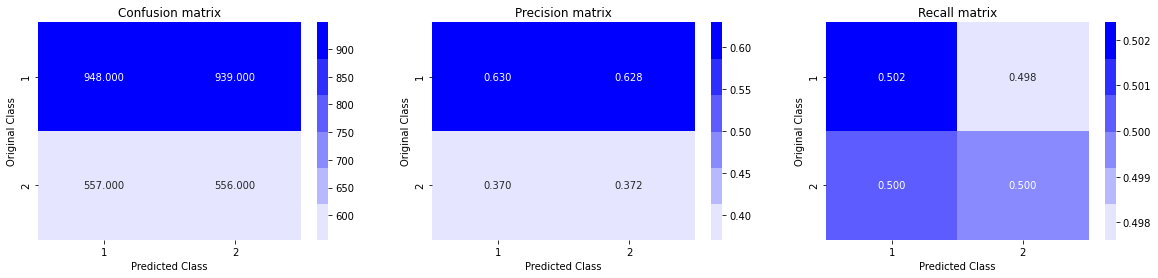

In [11]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6594859818900423
For values of alpha =  0.0001 The log loss is: 0.5970675407750495
For values of alpha =  0.001 The log loss is: 0.5287116964793278
For values of alpha =  0.01 The log loss is: 0.5401280404694473
For values of alpha =  0.1 The log loss is: 0.5251048373158498
For values of alpha =  1 The log loss is: 0.5213133033035107
For values of alpha =  10 The log loss is: 0.5493914695443498


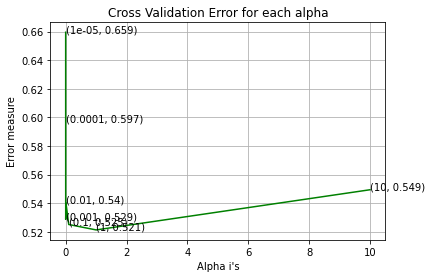

For values of best alpha =  1 The train log loss is: 0.49330891182391745
For values of best alpha =  1 The test log loss is: 0.5213133033035107
Total number of data points : 3000


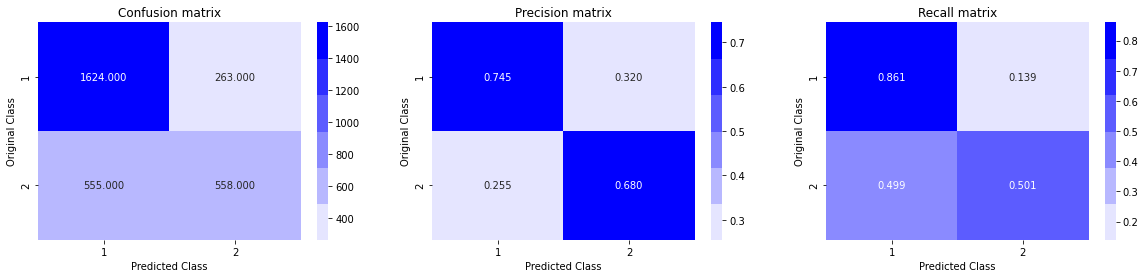

In [31]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6594859818900423
For values of alpha =  0.0001 The log loss is: 0.6594859818900423
For values of alpha =  0.001 The log loss is: 0.5769469637511894
For values of alpha =  0.01 The log loss is: 0.5374675502362167
For values of alpha =  0.1 The log loss is: 0.6108977202339422
For values of alpha =  1 The log loss is: 0.6306222091350422
For values of alpha =  10 The log loss is: 0.6594859818900423


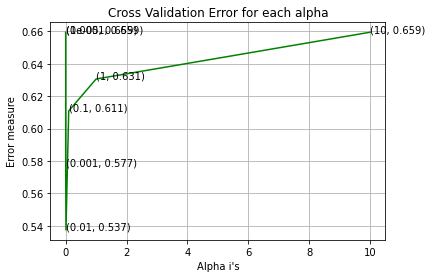

For values of best alpha =  0.01 The train log loss is: 0.5247626570849196
For values of best alpha =  0.01 The test log loss is: 0.5374675502362167
Total number of data points : 3000


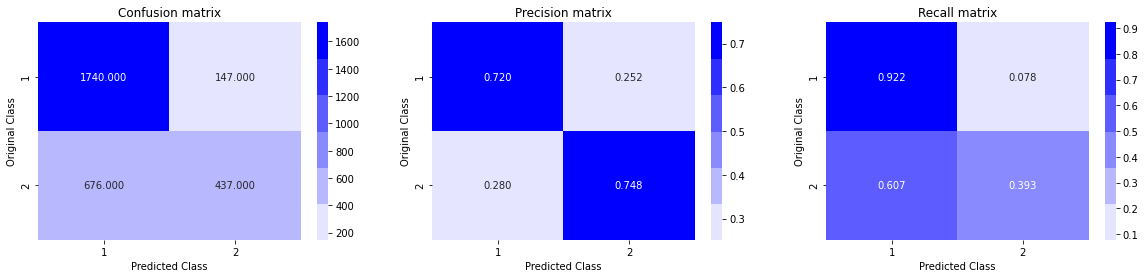

In [32]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBoost

In [33]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684603	valid-logloss:0.684824
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.613674	valid-logloss:0.615072
[20]	train-logloss:0.561924	valid-logloss:0.565697
[30]	train-logloss:0.522755	valid-logloss:0.528983
[40]	train-logloss:0.492162	valid-logloss:0.500648
[50]	train-logloss:0.467876	valid-logloss:0.478278
[60]	train-logloss:0.448621	valid-logloss:0.460753
[70]	train-logloss:0.432803	valid-logloss:0.446904
[80]	train-logloss:0.419811	valid-logloss:0.435674
[90]	train-logloss:0.408948	valid-logloss:0.426439
[100]	train-logloss:0.399637	valid-logloss:0.419013
[110]	train-logloss:0.391555	valid-logloss:0.412878
[120]	train-logloss:0.384979	valid-logloss:0.407855
[130]	train-logloss:0.379282	valid-logloss:0.403668
[140]	train-logloss:0.37411	valid-logloss:0.400289
[150]	train-logloss:0.369502	valid-logloss:0.397527
[160]	train-logloss:0.365375	

Total number of data points : 3000


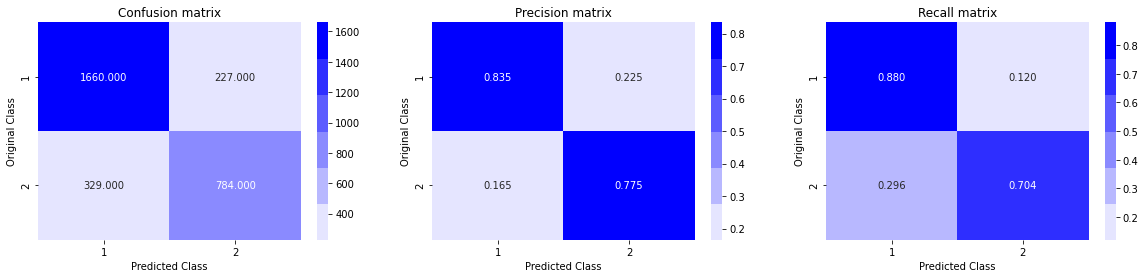

In [34]:
predicted_y = np.array(predict_y > 0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBoost with hyperparameter tuning

In [26]:
import xgboost as xgb

param_grid = {  
              'n_estimators': [40, 60, 80, 100], 
              'max_depth': range(1, 5), 
              'learning_rate': [1e-3, 1e-2, 1e-1], 
              'min_child_weight': range(1, 7), 
             }


grid = GridSearchCV(estimator= xgb.XGBClassifier(),
                    param_grid= param_grid,
                    scoring='neg_log_loss',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 43.4min finished


Best Score:  -0.3744111445460335
Best Params:  {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100}


In [39]:
model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 4, min_child_weight = 5, n_estimators = 100, eval_metric = 'logloss'
)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict_proba(X_test)

In [48]:
print("The train log loss is:",log_loss(y_train, model.predict_proba(X_train), eps=1e-15))
print("The test log loss is:",log_loss(y_test, y_pred, eps=1e-15))

The train log loss is: 0.284921427397415
The test log loss is: 0.37165811232745183


Total number of data points : 3000


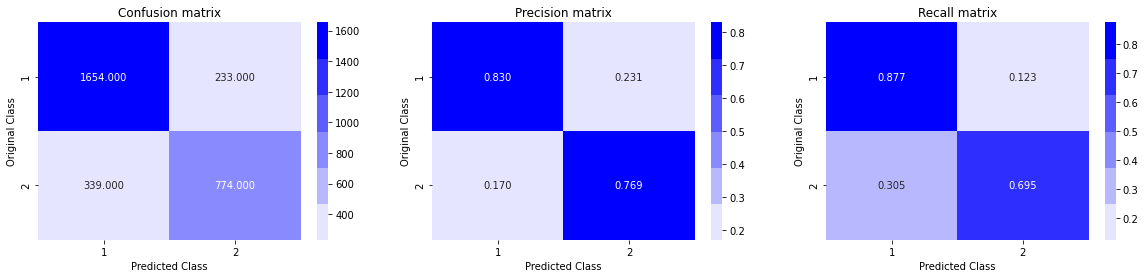

In [45]:
predicted_y =np.argmax(y_pred,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**Result:**
* Tokenizer= TFIDF Word2vec



|Model|Test Log loss|
| :- |:-|
|Random|0.8832|
|Logistic Regression|0.5213|
|Linear SVM|0.5374|
|XGBoost|0.3716|
